In [6]:
import hyperspy.api as hs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.stats as stats
from matplotlib import cm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import scipy as sp
from scipy.stats import skewnorm

In [9]:
def dataimporter(filename,header=70):
    # Reading in the data file, removing header and converting it to a matrix
    data = pd.read_csv(filename, header=header)
    nummer = data.to_numpy()
    nummerdata = np.asarray(nummer[:-1,:], dtype="float")
    return nummerdata
def plotter(ax,data,zo,colour,label,alpha = 1):
    # Function to plot spectrum
    ax.plot(data[:,0],data[:,1],zorder=zo, lw = 4, color = colour, label =label,alpha=alpha)
    ax.fill_between(data[:,0],data[:,1],zorder=zo, color = colour,alpha=alpha)
   
def find_nearest(array, value):
    # Function for finding closest value in array
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def data_integration(data,under=2.2,over=2.6,avgunder=2.65,avgover=2.8 ):
    # Function to integrate the data between energies
    array = np.array([])
    for i in (data):
        intunder = np.where(i[:,0]==find_nearest(i[:,0],under))
        intover = np.where(i[:,0]==find_nearest(i[:,0],over))
        placeunder = np.where(i[:,0]==find_nearest(i[:,0],avgunder))
        placeover = np.where(i[:,0]==find_nearest(i[:,0],avgover))
        
        intunder = np.reshape(intunder,-1)
        intover = np.reshape(intover,-1)
        placeunder = np.reshape(placeunder, -1)
        placeover = np.reshape(placeover, -1)

        # i[:,1] = i[:,1]-np.average(i[placeunder[0]:placeover[0],1])

        top1 = np.sum(i[intunder[0]:intover[0],1])
        array = np.append(array,top1)
    return array

def data_integration_new(data,under=2,over=2.8,marginal=0.1):
    # Function to integrate the data between energies
    array = np.array([])
    for i in (data):
        intunder = np.where(i[:,0]==find_nearest(i[:,0],under))[0][0]
        intover = np.where(i[:,0]==find_nearest(i[:,0],over))[0][0]
        x=i[intunder:intover,0]
        y = i[intunder:intover,1]
        
        mitten = x[np.argmax(y)]

        u = np.where(x==find_nearest(x,mitten-marginal))[0][0]
        ö = np.where(x==find_nearest(x,mitten+marginal))[0][0]
        x=x[u:ö]
        y = y[u:ö]

        poptnorm,pcov = sp.optimize.curve_fit(norm,xdata=x,ydata=y,p0=[1,1,1],maxfev=800)
        
        top1 =  np.sum(norm(x,*poptnorm))
        array = np.append(array,top1)
    return array

def predict(signal,c):
    return c[0]*signal + c[1]

def readfile(arraynames):
    # Funstion to make it possible to import multiple files at the same time
    meaner = np.array([])
    for i in arraynames:
        temp = dataimporter(i)
        meaner = np.append(meaner,data_integration([temp]))
    return meaner

def read_mapp_file(filepath):
    s = hs.load(filepath).as_signal1D(0)
    s.set_signal_type('EDS_SEM')
    s.set_elements(["O","S","Mo","Si"])
    s.axes_manager.signal_axes[0].units = 'keV'
    s.axes_manager[2].scale = 0.01
    
    
    thickenss = np.zeros([s.data.shape[0],s.data.shape[1]])
    a,b =s.axes_manager.signal_extent
    array = np.linspace(a,b,s.axes_manager.signal_shape[0])
    for i in range(s.data.shape[0]):
        for j in range(s.data.shape[1]):
            data = np.array([array,s.data[i,j,:]]).T
            
            try:
                thickenss[i,j] = predict(data_integration([data])[0],[ 0.03127056, -18.62270245])
            except:
                plt.plot(data[:,0],data[:,1])
                break
    
    return thickenss

def plotting3D(thickness,animation = False):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # Make data.
    X = np.arange(0,thickness.shape[1])
    Y = np.arange(0,thickness.shape[0])
    X1, Y1 = np.meshgrid(X, Y)
    # R = np.sqrt(X**2 + Y**2)
    Z = np.fliplr(np.flip(thickness))
    # Plot the surface.
    print(X1.shape,Y1.shape,Z.shape)
    region = np.s_[:192, :256]
    x, y, z = X1[region], Y1[region], Z[region]

    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)


    # Add a color bar which maps values to colors.
    # ax.view_init(0)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    
    
def skew_normal(x, a, loc, scale,amp):
    return amp*skewnorm.cdf(x, a, loc=loc, scale=scale)

def skew_normal_pdf(x, a, loc, scale,amp):
    return amp*skewnorm.pdf(x, a, loc=loc, scale=scale)
def norm(x,a,mean,sigma):
    return a*stats.norm.pdf(x,mean,sigma)

def invnorm(x,a,mean,sigma):
    return a*stats.invgauss.pdf(x,mean,sigma)

(96, 128)


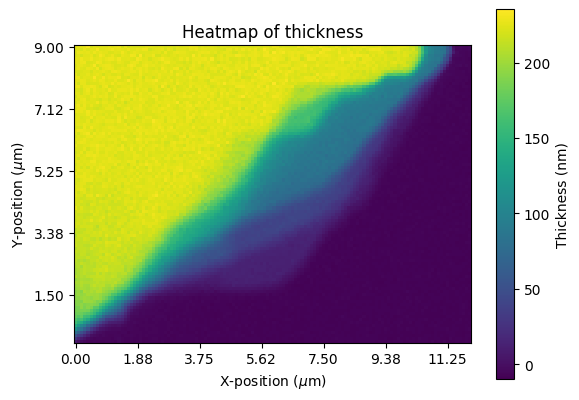

9.318626880000002


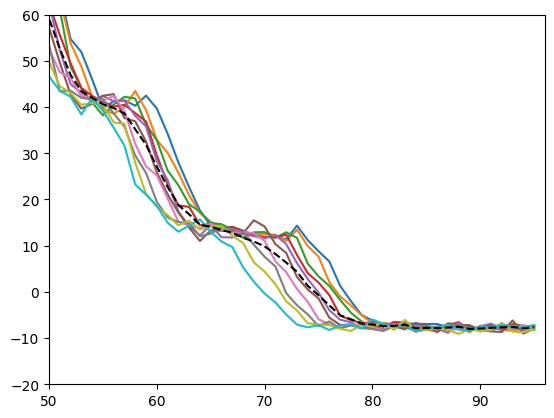

In [10]:
matris = read_mapp_file("mapdata/test128.rpl")
xarray = np.linspace(0,12,10)
yarray = np.linspace(0,9,10)
# plt.imshow(matris, cmap='viridis')
# plt.colorbar(label='Thickness (nm)')
# plt.title("Heatmap of thickness")
# plt.xlabel("X-position")
# plt.xlabel("Y-position")
# plt.show()
line = 70
print(matris.shape)
def fmty(x,pos):
    return f'{(1-x/96)*9:.2f}'
def fmtx(x,pos):
    return f'{(x/128)*12:.2f}'
fig, ax = plt.subplots()

ax.set_xlabel(r"X-position ($\mu$m)")
ax.set_ylabel(r"Y-position ($\mu$m)")
sak = ax.imshow(matris, cmap='viridis')
fig.colorbar(sak,ax=ax,label='Thickness (nm)')
ax.set_title("Heatmap of thickness")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(fmtx))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(fmty))
# ax.vlines((line-5,line,line+5),0,95)


plt.show()
# plt.plot(matris[:,line])
# plt.plot(matris[:,line-4])
# plt.plot(matris[:,line+4])
plt.plot(matris[:,line-5:line+5])

test = np.sum(matris[:,line-5:line+5],axis=1)
test /= 10
var = np.var(matris[:,line-5:line+5],axis=1)
plt.plot(test,linestyle="dashed",zorder=2,color = "black")
# plt.plot(var,linestyle="dashed",zorder=2,color = "grey")
print(np.max(matris[77,line-5:line+5])-np.min(matris[77,line-5:line+5]))

plt.xlim((50,96))
plt.ylim((-20,60))
plt.show()


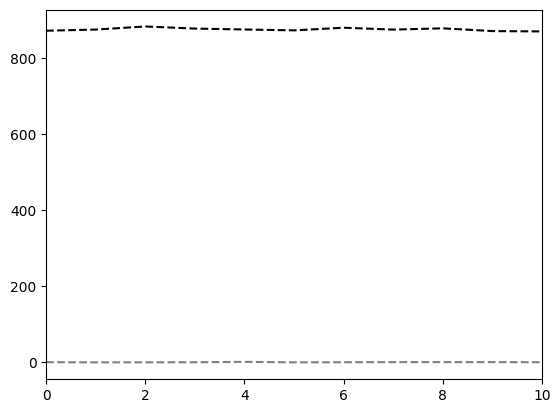

7.586709269150329


In [20]:
mean = np.sum(matris[:,line-5:line+5],axis=1)
# mean /= 10
var = np.var(matris[:,line-5:line+5],axis=1)
plt.plot(mean,linestyle="dashed",zorder=2,color = "black")
plt.plot(var,linestyle="dashed",zorder=2,color = "grey")
# print(np.max(matris[77,line-5:line+5])-np.min(matris[77,line-5:line+5]))

plt.xlim((0,10))
# plt.ylim((-20,60))
plt.show()

print(np.sum(var[:10]))

In [21]:
s = hs.load(filepath).as_signal1D(0)
matrix = s.data

NameError: name 'filepath' is not defined

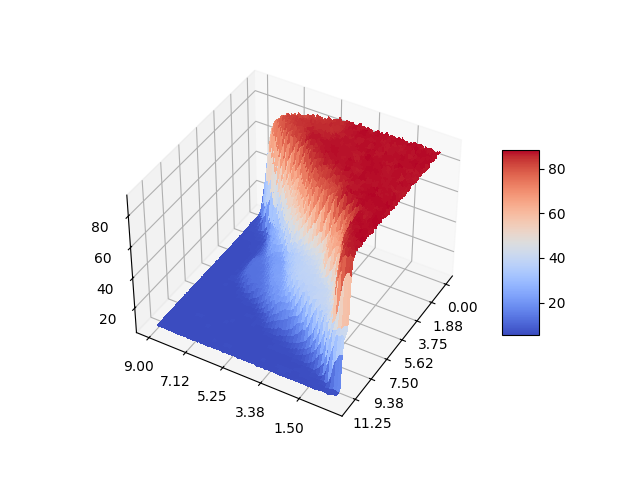

In [22]:
%matplotlib widget

def fmty(x,pos):
    return f'{(1-x/96)*9:.2f}'
def fmtx(x,pos):
    return f'{(x/128)*12:.2f}'

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(0,matris.shape[1])
Y = np.arange(0,matris.shape[0])
X1, Y1 = np.meshgrid(X, Y)
# R = np.sqrt(X**2 + Y**2)
Z = np.fliplr(np.flip(matris))
# Plot the surface.
# print(X1.shape,Y1.shape,Z.shape)
region = np.s_[:192, :256]
x, y, z = X1[region], Y1[region], Z[region]

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.xaxis.set_major_formatter(ticker.FuncFormatter(fmtx))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(fmty))

# Add a color bar which maps values to colors.
ax.view_init(40,30)
fig.colorbar(surf, shrink=0.5, aspect=5)
def animate(angle):
    ax.view_init(30, angle)

# ani = FuncAnimation(fig, animate, frames=range(360))
# writer = animation.PillowWriter(fps=15,metadata=dict(artist='Me'),bitrate=1800)
# ani.save('mapping_scale.gif', writer=writer)
plt.show()

(96, 128, 2048)


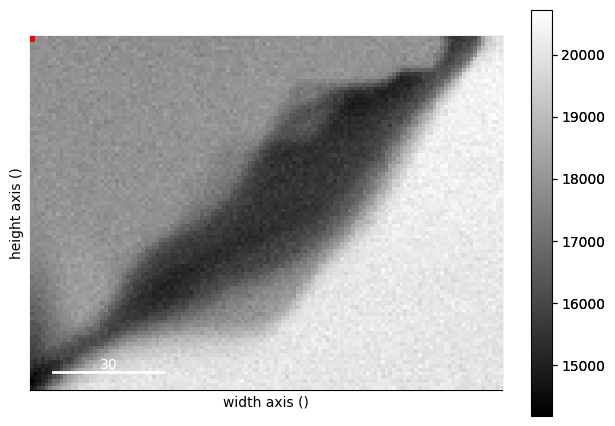

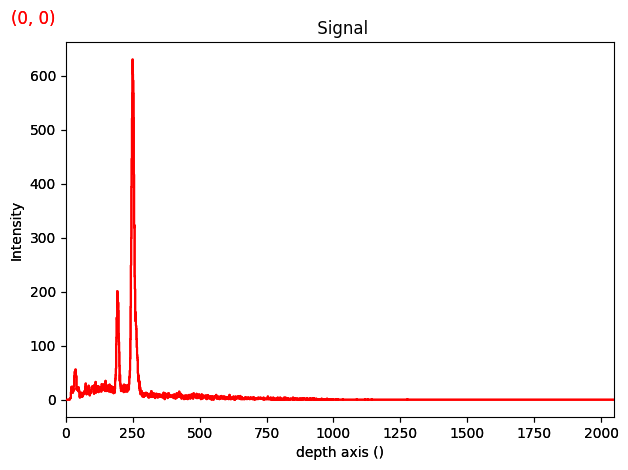

In [ ]:
m = hs.load("mapdata/test128.rpl").as_signal1D(0)
m.plot()
matr = m.data
# s.set_signal_type('EDS_SEM')
# s.set_elements(["O","S","Mo","Si"])
# s.axes_manager.signal_axes[0].units = 'keV'
# s.axes_manager[2].scale = 0.01


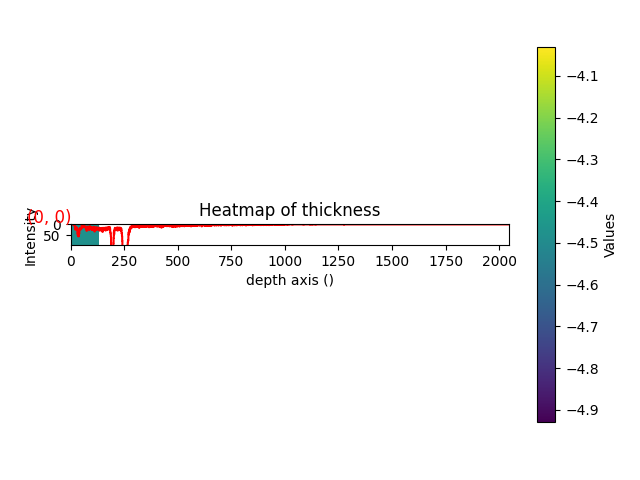

In [97]:
thickenss = np.zeros([m.data.shape[0],m.data.shape[1]])

a,b =m.axes_manager.signal_extent
array = np.linspace(a,b,m.axes_manager.signal_shape[0])
for i in range(m.data.shape[0]):
    for j in range(m.data.shape[1]):
        data = np.array([array,m.data[i,j,:]]).T
        thickenss[i,j] = predict(data_integration([data])[0],[ 0.00621576,-4.48010331])
        
plt.imshow(thickenss, cmap='viridis')
plt.colorbar(label='Values')
plt.title("Heatmap of thickness")
plt.show()

In [98]:
a,b =m.axes_manager.signal_extent
array = np.linspace(a,b,m.axes_manager.signal_shape[0])
data = np.array([array,m.data[10,10,:]]).T
plt.plot(array,m.data[10,10,:])

print(predict(data_integration([data])[0],[ 0.00621576,-4.48010331]))
# plt.plot(array,s.data[100,100,:])

-4.48010331
